In [1]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import numpy.ma as ma
import pandas as pd

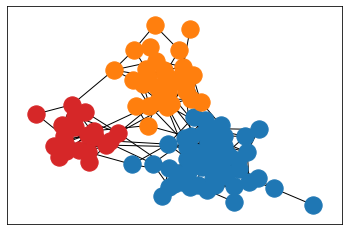

In [2]:
sizes = [20, 50, 30]
probs = [[0.25,0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 1/6]]
G = nx.stochastic_block_model(sizes, probs, seed=30)
A = nx.convert_matrix.to_numpy_matrix(G)

pos = nx.spring_layout(G, seed=3113794652)
nx.draw_networkx_nodes(G, pos, nodelist=range(0,sizes[0]), node_color="tab:red")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0], sizes[0]+sizes[1]), node_color="tab:blue")
nx.draw_networkx_nodes(G, pos, nodelist=range(sizes[0]+sizes[1], 100), node_color="tab:orange")
nx.draw_networkx_edges(G, pos)

# Run baseline strategy

1. Go if any of your friends went and it wasn't too crowded last time
2. Otherwise go with small random probability

In [15]:
def plot_mask(t, friends, mask, color):
    x = np.take(t, np.where(mask))
    y = np.take(friends, np.where(mask))
    plt.scatter(x=x, y=y,color=color)
    

def summarize_run(Xs):
    Xnp = np.hstack(Xs)
    attendance = np.ravel(Xnp.sum(axis=0))
    
    plt.figure()
    plt.plot(attendance)
    plt.plot([0, n_iter], [M, M], "--")
    plt.title("Attendance by week")
    
    plt.figure()

    too_full = attendance > 60

    # col j has the number of friends of each node
    # that attended on week j
    # mask agents that did not attend
    fma = ma.masked_array(A.dot(Xnp), 1-Xnp)
    # mean friend count per week
    friends = np.ravel(fma.mean(axis=0).data)
    too_full = Xnp.sum(axis=0) > 60

    t = range(len(friends))
    plot_mask(t, friends, too_full, "r")
    plot_mask(t, friends, [~c for c in too_full], "g")
    plt.title("Average friend count of attendees")

In [5]:
rng = np.random.default_rng()

# random initial conditions
X = rng.uniform(size=(100,1)) < 0.3
Xs = [X]
eps = 0.03 # small random probability for cold start
M = 60 # maximum capacity before it's too crowded
n_iter = 100

for _ in range(n_iter):
    if X.sum() < M:
        X  = A.dot(X) > 0
    else:
        X = np.zeros(shape=(100,1))

    X += rng.uniform(size=(100,1)) < eps
    Xs.append(X)

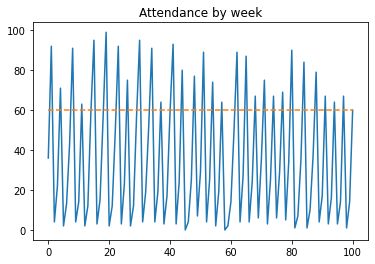

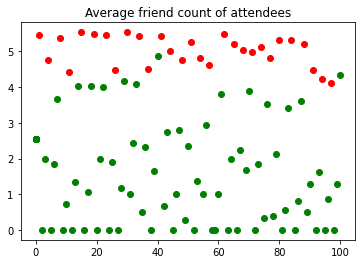

In [16]:
summarize_run(Xs)